Category 3 of the TF certification exam is a convolutional neural network with a real-world image dataset. This involves images which are colored and not uniform. The expectation is being able to use data augmentation and dropout for handling overfitting, as well as plotting training and testing. All of which is covered below.

Again, this is adapted from the [course](https://www.coursera.org/specializations/tensorflow-in-practice) cited for preparation.

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import numpy as np
import os
import zipfile

import matplotlib.pyplot as plt

from tensorflow import keras as k
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TensorFlow 2.x selected.


Here we make use of a pre-trained model to explore transfer learning, since we covered defining our own CNNs previously. Simply put transfer learning is taking the representations learnt by one model on some task and fine tuning them onto a new task. We can use any pretrained model for this, a bunch are available from `keras.applications`. Here we have used a 121-layer [DenseNet](https://arxiv.org/pdf/1608.06993.pdf).

In [0]:
# Load pretrained model

trained_model = k.applications.DenseNet121(input_shape = (150, 150, 3),
                                           # We don't want the linear layers
                                           include_top = False,
                                           # Pretrained weights to use
                                           weights = 'imagenet')

29089792/29084464 [==============================] - 3s 0us/step


In [0]:
# Freeze layers -  we do not explicitly have to freeze all the layers
# you can freeze the initial layers as they will be finding things like curves
# and edges, which are relevant to most datasets, whilst the higher layers
# will capture more complex characteristic which may not be relevant to our
# dataset. If this was the case, we would retrain some of the higher layers
# with a low learning rate. 

for layer in trained_model.layers:
  layer.trainable = False

In [0]:
# Grab last layer's output for passing to our network head which we will 
# define below.

final_layer_output = [layer for layer in trained_model.layers][-1].output

Overfitting can be prevented through [dropout](http://jmlr.org/papers/v15/srivastava14a.html) layers. Simply masking the outputs of neurons to zero randomly during training. The probability of each activation being 'turned-off' is the float value we pass.

In [0]:
# Define the head of our network, notice how the Model API may be used
# to define a sequence of layers. We are just passing our output from
# one layer to the next.

x = k.layers.Flatten()(final_layer_output)
x = k.layers.Dense(1024, activation='relu')(x)

# 20% chance of activation being masked to 0
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(1, activation='sigmoid')(x)

In [0]:
# Define a new model by glueing our head onto the pretrained model.

model = Model(trained_model.input, x)

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [0]:
# Get data

!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2020-03-17 11:49:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  78.2MB/s    in 0.8s    

2020-03-17 11:49:34 (78.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
# Extract data and set directories

zip_file = '/tmp/cats_and_dogs_filtered.zip'

zipper = zipfile.ZipFile(zip_file, 'r')
zipper.extractall('/tmp')
zipper.close()

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

Data augmentation is a popular method to prevent overfitting and to generalize our training data. It simply takes the input image and distorts it in some manner, such that it still looks the same, but might be a little squashed or rotated.

This is beneficial as our model may know what a cat looks like, but what about an upside down cat?

The data augmentation is provided by the `keras.preprocessing` class.

We obviously do not want to augment our testing images however. 

Below are a list of data augmentations used in this model, followed by a list of other possible augmentations.

In [0]:
# rotation_range (int): range of degrees to randomly rotate
# width_shift_range (float): range fraction of total width to shift
# height_shift_range (float): range fraction of total height to shift
# shear_range (float): Shear angle in counter-clockwise direction 
# zoom_range (float): range for random zoom.
# horizontal_flip (boolean): whether to randomly flip horizontally

# zca_whitening (boolean): whether to apply ZCA whitening
# brightness_range (tuple): range for random brightness shifts
# channel_shift_range (float): range for random channel shifts
# vertical_flip (boolean): whetehr to randomly flip vertically

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255.)

In [0]:
# flow training and testing data from directories

train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size=20,
                                              class_mode='binary',
                                              target_size=(150,150))

val_gen = val_datagen.flow_from_directory(val_dir,
                                          batch_size=20,
                                          class_mode='binary',
                                          target_size=(150,150))

# It is worth noting that the data generators also have the flow method
# which flows data from input/label pairs 

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# fit method returns the History callback, we use this
# for plotting our results later.

history = model.fit(train_gen, 
                    validation_data=val_gen,
                    # num samples = steps_per_epoch * batch
                    steps_per_epoch=100,
                    epochs=20,
                    validation_steps=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 32s 319ms/step - loss: 1.1280 - acc: 0.8420 - val_loss: 0.2207 - val_acc: 0.9530
Epoch 2/20
100/100 [==============================] - 19s 195ms/step - loss: 0.3203 - acc: 0.8840 - val_loss: 0.4121 - val_acc: 0.8970
Epoch 3/20
100/100 [==============================] - 19s 192ms/step - loss: 0.2253 - acc: 0.9050 - val_loss: 0.3865 - val_acc: 0.8940
Epoch 4/20
100/100 [==============================] - 19s 192ms/step - loss: 0.2222 - acc: 0.9090 - val_loss: 0.1253 - val_acc: 0.9710
Epoch 5/20
100/100 [==============================] - 20s 195ms/step - loss: 0.2339 - acc: 0.8985 - val_loss: 0.2080 - val_acc: 0.9400
Epoch 6/20
100/100 [==============================] - 20s 197ms/step - loss: 0.1967 - acc: 0.9075 - val_loss: 0.1374 - val_acc: 0.9610
Epoch 7/20
100/100 [==============================] - 20s 197ms/step - loss: 0.2094 - acc: 0.9140

We can easily access the training and validation results through the `History` callback. Below we plot the accuracy and loss for training and validation.

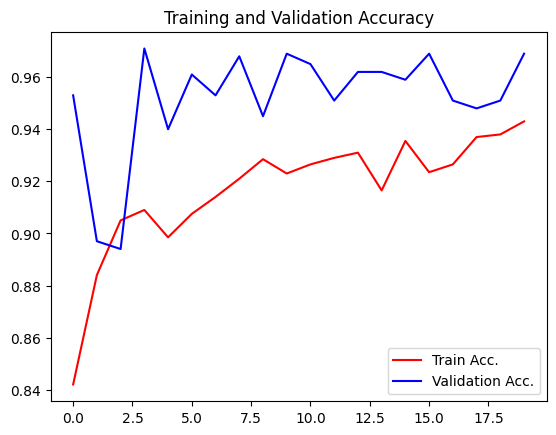

<Figure size 640x480 with 0 Axes>

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.rcdefaults()
plt.plot(epochs, acc, 'r', label='Train Acc.')
plt.plot(epochs, val_acc, 'b', label='Validation Acc.')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()